<a href="https://colab.research.google.com/github/donalhill/portfolio-projects/blob/main/NLP_PubMed.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Text classification with machine learning (Natural Language Processing)

In this notebook, I explore the application of deep learning NLP models to a text classification problem. I aim to replicate the paper [PubMed 200k RCT: a Dataset for Sequenctial Sentence Classification in Medical Abstracts](https://arxiv.org/abs/1710.06071), where sequential sentences in medical journal abstracts are classified according to their role (e.g. objective, methods, results).



### Imports



In [106]:
import sys, os
import pandas as pd
import random
import string
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers
import matplotlib.pyplot as plt
from tensorflow.keras.layers.experimental.preprocessing import TextVectorization
import tensorflow_hub as hub
from tensorflow.keras.utils import plot_model

### Confirm GPU access

In [1]:
!nvidia-smi -L

GPU 0: Tesla T4 (UUID: GPU-c6011f43-41de-c992-2b91-63b2ab976721)


### Get data 

The authors of the paper have made the data they used for their research availably in the form of .txt files on GitHub.

We can copy them to our local directory using `git clone`.

In [2]:
!git clone https://github.com/Franck-Dernoncourt/pubmed-rct.git
!ls pubmed-rct

Cloning into 'pubmed-rct'...
remote: Enumerating objects: 33, done.
remote: Counting objects: 100% (8/8), done.
remote: Compressing objects: 100% (3/3), done.
remote: Total 33 (delta 5), reused 5 (delta 5), pack-reused 25
Unpacking objects: 100% (33/33), done.
PubMed_200k_RCT
PubMed_200k_RCT_numbers_replaced_with_at_sign
PubMed_20k_RCT
PubMed_20k_RCT_numbers_replaced_with_at_sign
README.md


To begin with, the dataset we're going to be focused on is `PubMed_20k_RCT_numbers_replaced_with_at_sign`. This will keep our experiments quick rather than working with the full 200k dataset. We will work with files where all numerical values have been replaced with @ signs.

Let's check the file contents.

In [3]:
!ls pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign

dev.txt  test.txt  train.txt


We have three separate samples for training, model development, and testing. 

In [6]:
data_dir = "pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/"
filenames = [data_dir + filename for filename in os.listdir(data_dir)]
filenames

['pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/test.txt',
 'pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/train.txt',
 'pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/dev.txt']

### Preprocess data

Function to read each line from a text file.

In [7]:
def get_lines(filename):
  """
  Reads filename (a text file) and returns the lines of text as a list.
  
  Args:
      filename: a string containing the target filepath to read.
  
  Returns:
      A list of strings with one string per line from the target filename.
      For example:
      ["this is the first line of filename",
       "this is the second line of filename",
       "..."]
  """
  with open(filename, "r") as f:
    return f.readlines()

In [8]:
train_lines = get_lines(data_dir+"train.txt")
train_lines[:20] # the whole first example of an abstract + a little more of the next one

['###24293578\n',
 'OBJECTIVE\tTo investigate the efficacy of @ weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at @ weeks in older adults with moderate to severe knee osteoarthritis ( OA ) .\n',
 'METHODS\tA total of @ patients with primary knee OA were randomized @:@ ; @ received @ mg/day of prednisolone and @ received placebo for @ weeks .\n',
 'METHODS\tOutcome measures included pain reduction and improvement in function scores and systemic inflammation markers .\n',
 'METHODS\tPain was assessed using the visual analog pain scale ( @-@ mm ) .\n',
 'METHODS\tSecondary outcome measures included the Western Ontario and McMaster Universities Osteoarthritis Index scores , patient global assessment ( PGA ) of the severity of knee OA , and @-min walk distance ( @MWD ) .\n',
 'METHODS\tSerum levels of interleukin @ ( IL-@ ) , IL-@ , tumor necrosis factor ( TNF ) - , and 

Reading the lines from the training text file results in a list of strings containing different abstract samples, the sentences in a sample, and the role each sentence plays in the abstract.

Different abstracts are separated by abstract ID's (lines beginning with `###`) and newlines `\n`.

We have a couple of steps to get our samples ready to pass as training data to our future machine learning model. Let's write a function to:

* Take a target file of abstract samples.
* Read the lines in the target file.
*For each line in the target file:
  * If the line begins with `###`, mark it as an abstract ID and the beginning of a new abstract.
    * Keep count of the number of lines in a sample.
  * If the line begins with `\n`, mark it as the end of an abstract sample.
    * Keep count of the total lines in a sample.
  * Record the text before the `\t` as the label of the line.
  * Record the text after the `\t` as the text of the line.
* Return all lines in the target text file as a list of dictionaries containing the key/value pairs:
  * "line_number" - the position of the line in the abstract (e.g. 3).
  * "target" - the role of the line in the abstract (e.g. OBJECTIVE).
  * "text" - the text of the line in the abstract.
  * "total_lines" - the total lines in an abstract sample (e.g. 14).
* Abstract ID's and newlines should be omitted from the returned preprocessed data.

In [9]:
def preprocess_text_with_line_numbers(filename):
  """Returns a list of dictionaries of abstract line data.

  Takes in filename, reads its contents and sorts through each line,
  extracting things like the target label, the text of the sentence,
  how many sentences are in the current abstract, and what sentence number
  the target line is.

  Args:
      filename: a string of the target text file to read and extract line data
      from.

  Returns:
      A list of dictionaries each containing a line from an abstract,
      the lines label, the lines position in the abstract, and the total number
      of lines in the abstract where the line is from. 
  """
  input_lines = get_lines(filename) # get all lines from filename
  abstract_lines = "" # create an empty abstract
  abstract_samples = [] # create an empty list of abstracts
  
  # Loop through each line in target file
  for line in input_lines:
    if line.startswith("###"): # check to see if line is an ID line
      abstract_id = line
      abstract_lines = "" # reset abstract string
    elif line.isspace(): # check to see if line is a new line
      abstract_line_split = abstract_lines.splitlines() # split abstract into separate lines

      # Iterate through each line in abstract and count them at the same time
      for abstract_line_number, abstract_line in enumerate(abstract_line_split):
        line_data = {} # create empty dict to store data from line
        target_text_split = abstract_line.split("\t") # split target label from text
        line_data["target"] = target_text_split[0] # get target label
        line_data["text"] = target_text_split[1].lower() # get target text and lower it
        line_data["line_number"] = abstract_line_number # what number line does the line appear in the abstract?
        line_data["total_lines"] = len(abstract_line_split) - 1 # how many total lines are in the abstract? (start from 0)
        abstract_samples.append(line_data) # add line data to abstract samples list
    
    else: # if the above conditions aren't satisfied, the line contains a labelled sentence
      abstract_lines += line
  
  return abstract_samples

Let's use it to process our train, dev, and test samples.

In [12]:
datasets = ["train","dev","test"]
samples = {}
for d in datasets:
  samples[d] = preprocess_text_with_line_numbers(data_dir + f"{d}.txt")

Check how our training samples look:

In [13]:
samples["train"][:14]

[{'line_number': 0,
  'target': 'OBJECTIVE',
  'text': 'to investigate the efficacy of @ weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at @ weeks in older adults with moderate to severe knee osteoarthritis ( oa ) .',
  'total_lines': 11},
 {'line_number': 1,
  'target': 'METHODS',
  'text': 'a total of @ patients with primary knee oa were randomized @:@ ; @ received @ mg/day of prednisolone and @ received placebo for @ weeks .',
  'total_lines': 11},
 {'line_number': 2,
  'target': 'METHODS',
  'text': 'outcome measures included pain reduction and improvement in function scores and systemic inflammation markers .',
  'total_lines': 11},
 {'line_number': 3,
  'target': 'METHODS',
  'text': 'pain was assessed using the visual analog pain scale ( @-@ mm ) .',
  'total_lines': 11},
 {'line_number': 4,
  'target': 'METHODS',
  'text': 'secondary outcome measures include

We can turn our dictionaries into `pandas` DataFrames to help visualise them better:

In [17]:
df = {}

for d in datasets:
  df[d] = pd.DataFrame(samples[d])
df["train"].head(14)

,target,text,line_number,total_lines
0,OBJECTIVE,to investigate the efficacy of @ weeks of dail...,0,11
1,METHODS,a total of @ patients with primary knee oa wer...,1,11
2,METHODS,outcome measures included pain reduction and i...,2,11
3,METHODS,pain was assessed using the visual analog pain...,3,11
4,METHODS,secondary outcome measures included the wester...,4,11
5,METHODS,"serum levels of interleukin @ ( il-@ ) , il-@ ...",5,11
6,RESULTS,there was a clinically relevant reduction in t...,6,11
7,RESULTS,the mean difference between treatment arms ( @...,7,11
8,RESULTS,"further , there was a clinically relevant redu...",8,11
9,RESULTS,these differences remained significant at @ we...,9,11


Check the distribution of labels in the training data:

In [18]:
df["train"]["target"].value_counts()

METHODS        59353
RESULTS        57953
CONCLUSIONS    27168
BACKGROUND     21727
OBJECTIVE      13839
Name: target, dtype: int64

It looks like sentences labelled as `OBJECTIVE` are the least common type of sentence in our training abstracts.

We can also check the distribution of abstract lengths:

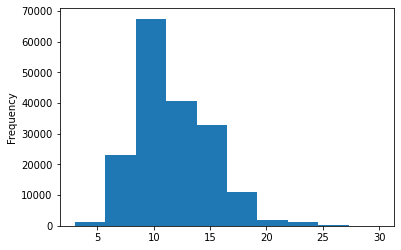

In [19]:
df["train"]["total_lines"].plot.hist();

So our abstracts range in length from around 5 to 25 sentences, with the most common length being 10. This is a good sense-check that none of our samples have unreasonable lengths.



### Get lists of sentences

When we build our deep learning model, one of its main inputs will be a list of strings (the lines of an abstract). We can get these from our DataFrames by calling the `tolist()` method on the "text" columns.



In [22]:
sentences = {}
for d in datasets:
  sentences[d] = df[d]["text"].tolist()
  print(len(sentences[d]))

180040
30212
30135


First ten lines of training sentences:

In [23]:
sentences["train"][:10]

['to investigate the efficacy of @ weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at @ weeks in older adults with moderate to severe knee osteoarthritis ( oa ) .',
 'a total of @ patients with primary knee oa were randomized @:@ ; @ received @ mg/day of prednisolone and @ received placebo for @ weeks .',
 'outcome measures included pain reduction and improvement in function scores and systemic inflammation markers .',
 'pain was assessed using the visual analog pain scale ( @-@ mm ) .',
 'secondary outcome measures included the western ontario and mcmaster universities osteoarthritis index scores , patient global assessment ( pga ) of the severity of knee oa , and @-min walk distance ( @mwd ) .',
 'serum levels of interleukin @ ( il-@ ) , il-@ , tumor necrosis factor ( tnf ) - , and high-sensitivity c-reactive protein ( hscrp ) were measured .',
 'there was a clinic

ML modes don't understand text, so we will need to convert the text to numbers before we can use it with our machine learning models. We will cover this soon.

### Make numeric labels for ML model

We're going to create one-hot and label-encoded labels. We could just make label-encoded labels, but the TensorFlow `CategoricalCrossentropy` loss function likes to have one-hot encoded labels (this will enable us to use label smoothing later on).

To numerically encode labels we use the scikit-learn `OneHotEncoder` and `LabelEncoder` classes.

In [61]:
one_hot_encoder = OneHotEncoder(sparse=False)
labels_one_hot = {}

for d in datasets:
  labels_one_hot[d] = one_hot_encoder.fit_transform(df[d]["target"].to_numpy().reshape(-1, 1))

# Check what training labels look like
labels_one_hot["train"]

array([[0., 0., 0., 1., 0.],
       [0., 0., 1., 0., 0.],
       [0., 0., 1., 0., 0.],
       ...,
       [0., 0., 0., 0., 1.],
       [0., 1., 0., 0., 0.],
       [0., 1., 0., 0., 0.]])

In [35]:
label_encoder = LabelEncoder()
labels_encoded = {}

for d in datasets:
  labels_encoded[d] = label_encoder.fit_transform(df[d]["target"].to_numpy())

# Check what training labels look like
labels_encoded["train"]

array([3, 2, 2, ..., 4, 1, 1])

We can get the class names and number of classes using the `classes_` attribute:

In [31]:
num_classes = len(label_encoder.classes_)
class_names = label_encoder.classes_
num_classes, class_names

(5, array(['BACKGROUND', 'CONCLUSIONS', 'METHODS', 'OBJECTIVE', 'RESULTS'],
       dtype=object))

## Creating a series of model experiments

We've proprocessed our data, so now we can set up a series of modelling experiments.

We'll start by creating a simple baseline model to obtain a score we'll try to beat with increasingly complex models, as we move towards replicating the sequence model outlined in the paper. 

For each model, we'll train it on the training data and evaluate it on the dev data.

## Model 0: baseline

Our first model we'll be a TF-IDF Multinomial Naive Bayes, as recommended by Scikit-Learn's machine learning [map](https://scikit-learn.org/stable/tutorial/machine_learning_map/index.html).

To build it, we'll create a scikit-learn `Pipeline` which uses the `TfidfVectorizer` class to convert our abstract sentences to numbers using the TF-IDF (term frequency-inverse document frequecy) algorithm, and then learns to classify our sentences using the `MultinomialNB` aglorithm.

In [33]:
# Create a pipeline
model_0 = Pipeline([
  ("tf-idf", TfidfVectorizer()),
  ("clf", MultinomialNB())
])

# Fit the pipeline to the training data
model_0.fit(X=sentences["train"], 
            y=labels_encoded["train"])

Pipeline(steps=[('tf-idf', TfidfVectorizer()), ('clf', MultinomialNB())])

We can evaluate the accuracy of `model_0` on the validation dataset, using the `score()` method:

In [36]:
model_0.score(X=sentences["dev"],
              y=labels_encoded["dev"])

0.7218323844829869

Looks like 72.2% will be the score to beat with our deeper models. We can also make predictions with our baseline model, to evaluate it further.

In [37]:
baseline_preds = model_0.predict(sentences["dev"])
baseline_preds

array([4, 1, 3, ..., 4, 4, 1])

To evaluate our baseline models predictions by comparing them to the ground truth labels, we'll import the `calculate_results()` function from a `helper_functions.py` script. This function will help us obtain:
* Accuracy
* Precision
* Recall
* F1-score

We can retrieve the script from my GitHub portfolio repo:

In [38]:
!wget https://raw.githubusercontent.com/donalhill/portfolio-projects/main/helper_functions.py

--2022-05-11 11:33:01--  https://raw.githubusercontent.com/donalhill/portfolio-projects/main/helper_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.110.133, 185.199.109.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10246 (10K) [text/plain]
Saving to: ‘helper_functions.py’

helper_functions.py 100%[===================>]  10.01K  --.-KB/s    in 0s      

2022-05-11 11:33:02 (104 MB/s) - ‘helper_functions.py’ saved [10246/10246]



In [39]:
# Import calculate_results helper function
from helper_functions import calculate_results

In [40]:
# Calculate baseline results
baseline_results = calculate_results(y_true=labels_encoded["dev"],
                                     y_pred=baseline_preds)
baseline_results

{'accuracy': 72.1832384482987,
 'f1': 0.6989250353450294,
 'precision': 0.7186466952323352,
 'recall': 0.7218323844829869}

## Preparing our data for deep sequence models

Before we start building deeper models, we need to create vectorisation and embedding layers. The vectorisation layer will convert our text to numbers, and the embedding layer will capture the relationships between those numbers.

Since we'll be turning our sentences into numbers, it's a good idea to figure out how many words are in each sentence. When our model goes through our sentences, it works best when they are all the same length (this is important for creating batches of the same-size tensors). For example, if one sentence is eight words long and another is 29 words long, we want to pad the eight-word sentence with zeros so it ends up being the same length as the 29-word sentence.

We can find the average length of sentences in the training set:

In [43]:
# How long is each sentence on average?
sent_lens = [len(sentence.split()) for sentence in sentences["train"]]
avg_sent_len = np.mean(sent_lens)
avg_sent_len # return average sentence length (in tokens)

26.338269273494777

We can also check the distribution of sentence length:

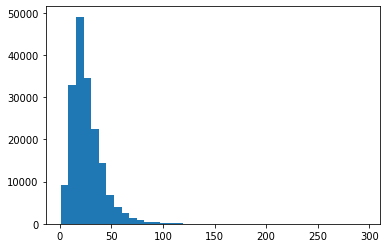

In [46]:
plt.hist(sent_lens, bins=40);

The majority of sentences are between 0 and 50 tokens in length. We can use the numpy `percentile` function to find the value which covers 95% of the sentence lengths.

In [47]:
# How long are 95% of sentences?
output_seq_len = int(np.percentile(sent_lens, 95))
output_seq_len

55

When we create our tokenisation layer, we'll use this value to turn all of our sentences into the same length. Sentences with a length below 55 get padded with zeros, and sentences with a length above 55 get truncated.

We could also use the max sentence length of the sentences in the training set:

In [48]:
max(sent_lens)

296

Hardly any sentences come anywhere close to the max length, so the majority of the data we pass to our model would be padded with zeros. Using a percentile approach avoids this problem.

### Create text vectorizer

We will use the `TextVectorization` layer from TensorFlow. We keep all the parameters default except for `max_tokens` (the number of unique words in our dataset) and `output_sequence_length` (our desired output length for each vectorised sentence).

Section 3.2 of the paper we are replicating states that the vocabulary size of the PubMed 20k dataset is `68,000`; we thus use this as our `max_tokens` parameter.



In [49]:
max_tokens = 68000

In [52]:
# Create text vectorizer
text_vectorizer = TextVectorization(max_tokens=max_tokens, # number of words in vocabulary
                                    output_sequence_length=output_seq_len) # desired output length of vectorized sequences

Let's adapt it to the training data (let it read the training data and figure out what number should represent what word), and then test it out.

In [53]:
text_vectorizer.adapt(sentences["train"])

In [55]:
target_sentence = random.choice(sentences["train"])
print(f"Text:\n{target_sentence}")
print(f"\nLength of text: {len(target_sentence.split())}")
print(f"\nVectorized text:\n{text_vectorizer([target_sentence])}")

Text:
toc may be a promising , brief intervention for adolescents seeking emergency services and at risk of suicide .

Length of text: 19

Vectorized text:
[[13623    91    36     8  1382   960    38    11   687  3128   921   945
      3    15    73     4  2793     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0]]


Using the `get_vocabulary()` method of our `text_vectorizer`, we can find out a few different things about our text:

In [57]:
rct_20k_text_vocab = text_vectorizer.get_vocabulary()
print(f"Number of words in vocabulary: {len(rct_20k_text_vocab)}"), 
print(f"Most common words in the vocabulary: {rct_20k_text_vocab[:5]}") #first five
print(f"Least common words in the vocabulary: {rct_20k_text_vocab[-5:]}") #last five

Number of words in vocabulary: 64841
Most common words in the vocabulary: ['', '[UNK]', 'the', 'and', 'of']
Least common words in the vocabulary: ['aainduced', 'aaigroup', 'aachener', 'aachen', 'aaacp']


If we wanted to figure out the configuration of our `text_vectorizer`, we can use the `get_config()` method:

In [58]:
text_vectorizer.get_config()

{'batch_input_shape': (None,),
 'dtype': 'string',
 'idf_weights': None,
 'max_tokens': 68000,
 'name': 'text_vectorization',
 'ngrams': None,
 'output_mode': 'int',
 'output_sequence_length': 55,
 'pad_to_max_tokens': False,
 'ragged': False,
 'sparse': False,
 'split': 'whitespace',
 'standardize': 'lower_and_strip_punctuation',
 'trainable': True,
 'vocabulary': None}

###Create custom text embedding

Our `text_vectorizer` layer maps the words in our text directly to numbers. However, this doesn't necessarily capture the relationships between those numbers. To create a richer numerical representation of our text, we can use an embedding.

As our model learns (by going through many different examples of abstract sentences and their labels), it will update its embedding to better represent the relationships between tokens in our corpus.

We can create a trainable embedding layer using the TensorFlow `Embedding` layer. The `input_dim` parameter defines the size of our vocabulary, and the `output_dim` parameter defines the dimension of the embedding output.

Once created, our embedding layer will take the integer outputs of our `text_vectorizer` layer as inputs and convert them to feature vectors of size `output_dim`.

In [59]:
# Create token embedding layer
token_embed = layers.Embedding(input_dim=len(rct_20k_text_vocab), # length of vocabulary
                               output_dim=128, #Different embedding sizes result in drastically different numbers of parameters to train
                               # Use masking to handle variable sequence lengths (save space)
                               mask_zero=True,
                               name="token_embedding") 

# Show example embedding
print(f"Sentence before vectorization:\n{target_sentence}\n")
vectorized_sentence = text_vectorizer([target_sentence])
print(f"Sentence after vectorization (before embedding):\n{vectorized_sentence}\n")
embedded_sentence = token_embed(vectorized_sentence)
print(f"Sentence after embedding:\n{embedded_sentence}\n")
print(f"Embedded sentence shape: {embedded_sentence.shape}")

Sentence before vectorization:
toc may be a promising , brief intervention for adolescents seeking emergency services and at risk of suicide .

Sentence after vectorization (before embedding):
[[13623    91    36     8  1382   960    38    11   687  3128   921   945
      3    15    73     4  2793     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0]]

Sentence after embedding:
[[[ 1.5743822e-04 -1.2633681e-02  4.2677786e-02 ... -3.1439915e-02
    3.3184234e-02  1.9155454e-02]
  [-3.2643974e-02  2.7512658e-02  3.1285319e-02 ... -4.1771997e-02
    4.4641819e-02  1.9428879e-04]
  [-4.9504902e-02  2.1981075e-04  4.4041399e-02 ...  2.8328076e-03
    2.5163498e-02 -3.4418415e-02]
  ...
  [ 4.4544805e-02 -3.9464545e-02  2.7406961e-05 ...  3.3127274e-02
   -5.0641522e-03  4.5549385e-03]
  [ 4.4544805e-02 -3.9464545

## Create datasets

There are still a few steps we can use to make our datasets work faster with our deep models. The `tf.data` API provides methods which enable faster data loading.

The main thing we'll want to do with our data is to turn it into a `PrefetchDataset` of batches. Doing this will ensure TensorFlow loads our data onto the GPU as fast as possible, in turn leading to faster training times.

To create a batched `PrefetchDataset`, we can use the methods `batch()` and `prefetch()`. The parameter `tf.data.AUTOTUNE` will also allow TensorFlow to determine the optimal amount of compute to use to prepare datasets.

In [62]:
# Turn our data into TensorFlow Datasets
tf_datasets = {}
for d in datasets:
  tf_datasets[d] = tf.data.Dataset.from_tensor_slices((sentences[d], labels_one_hot[d]))

tf_datasets["train"]

<TensorSliceDataset element_spec=(TensorSpec(shape=(), dtype=tf.string, name=None), TensorSpec(shape=(5,), dtype=tf.float64, name=None))>

In [63]:
# Take the TensorSliceDataset's and turn them into prefetched batches
for d in datasets:
  tf_datasets[d] = tf_datasets[d].batch(32).prefetch(tf.data.AUTOTUNE)
tf_datasets["train"]

<PrefetchDataset element_spec=(TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>

## Model 1: Conv1D with token embeddings

All of our deep models will follow a similar structure:

`Input (text) -> Tokenize -> Embedding -> Layers -> Output (label probability)`

The main component we'll be changing throughout is the `Layers` component, because any modern deep NLP model requires text to be converted into an embedding before meaningful patterns can be discovered.

The first model we're going to build is a 1-dimensional Convolutional Neural Network.

In [64]:
# Create 1D convolutional model to process sequences
inputs = layers.Input(shape=(1,), dtype=tf.string)
text_vectors = text_vectorizer(inputs) # vectorize text inputs
token_embeddings = token_embed(text_vectors) # create embedding
x = layers.Conv1D(64, kernel_size=5, padding="same", activation="relu")(token_embeddings)
x = layers.GlobalAveragePooling1D()(x) # condense the output of our feature vector
outputs = layers.Dense(num_classes, activation="softmax")(x)
model_1 = tf.keras.Model(inputs, outputs)

# Compile
model_1.compile(loss="categorical_crossentropy", # if your labels are integer form (not one hot) use sparse_categorical_crossentropy
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

In [65]:
# Get summary of Conv1D model
model_1.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 1)]               0         
                                                                 
 text_vectorization (TextVec  (None, 55)               0         
 torization)                                                     
                                                                 
 token_embedding (Embedding)  (None, 55, 128)          8299648   
                                                                 
 conv1d (Conv1D)             (None, 55, 64)            41024     
                                                                 
 global_average_pooling1d (G  (None, 64)               0         
 lobalAveragePooling1D)                                          
                                                                 
 dense (Dense)               (None, 5)                 325   

The majority of the trainable parameters are within the embedding layer. If we were to increase the size of the embedding (by increasing the output_dim parameter of the Embedding layer), the number of trainable parameters would increase dramatically.

It's time to fit our model to the training data. We use only use the first 10% of batches (about 18,000 samples) of the training set to train on and the first 10% of batches from the validation set to validate on.

In [66]:
# Fit the model
model_1_history = model_1.fit(tf_datasets["train"],
                              steps_per_epoch=int(0.1 * len(tf_datasets["train"])), # only fit on 10% of batches for faster training time
                              epochs=3,
                              validation_data=tf_datasets["dev"],
                              validation_steps=int(0.1 * len(tf_datasets["dev"]))) # only validate on 10% of batches

Epoch 1/3
562/562 [==============================] - 16s 9ms/step - loss: 0.9212 - accuracy: 0.6373 - val_loss: 0.6875 - val_accuracy: 0.7417
Epoch 2/3
562/562 [==============================] - 5s 8ms/step - loss: 0.6566 - accuracy: 0.7588 - val_loss: 0.6297 - val_accuracy: 0.7713
Epoch 3/3
562/562 [==============================] - 5s 8ms/step - loss: 0.6154 - accuracy: 0.7760 - val_loss: 0.5947 - val_accuracy: 0.7816


Time to make some predictions with our model and then evaluate them.

In [67]:
# Evaluate on whole validation dataset (we only validated on 10% of batches during training)
model_1.evaluate(tf_datasets["dev"])

945/945 [==============================] - 3s 3ms/step - loss: 0.5955 - accuracy: 0.7858


[0.5955126881599426, 0.7857804894447327]

In [68]:
# Make predictions (our model outputs prediction probabilities for each class)
model_1_pred_probs = model_1.predict(tf_datasets["dev"])
model_1_pred_probs

array([[4.3725470e-01, 1.5678127e-01, 7.9430439e-02, 3.0480283e-01,
        2.1730697e-02],
       [4.0235108e-01, 3.4404048e-01, 1.2845161e-02, 2.3295328e-01,
        7.8100059e-03],
       [1.3525073e-01, 5.2294172e-03, 1.4494435e-03, 8.5804242e-01,
        2.7994505e-05],
       ...,
       [7.6401684e-06, 6.7931059e-04, 7.8072725e-04, 3.5796968e-06,
        9.9852872e-01],
       [4.7904879e-02, 4.6322203e-01, 8.0707476e-02, 6.1879903e-02,
        3.4628567e-01],
       [1.9888119e-01, 6.5212035e-01, 5.6906641e-02, 4.1352913e-02,
        5.0738916e-02]], dtype=float32)

In [69]:
# Convert pred probs to classes (by finding the class with largest probability score)
model_1_preds = tf.argmax(model_1_pred_probs, axis=1)
model_1_preds

<tf.Tensor: shape=(30212,), dtype=int64, numpy=array([0, 0, 3, ..., 4, 1, 1])>

In [70]:
# Calculate model_1 results
model_1_results = calculate_results(y_true=labels_encoded["dev"],
                                    y_pred=model_1_preds)
model_1_results

{'accuracy': 78.57804845756652,
 'f1': 0.7831291628780391,
 'precision': 0.7824342821783506,
 'recall': 0.7857804845756653}

## Model 2: Feature extraction with pretrained token embeddings

Training our own embeddings took a little while to run, slowing our experiments down. Since we're moving towards replicating the model architecture in the paper, it mentions they used a pretrained `GloVe` embedding as a way to initialise their token embeddings. To emulate this, let's see what results we can get with the pretrained Universal Sentence Encoder embeddings from TensorFlow Hub.

The model structure will look like:

`Inputs (string) -> Pretrained embeddings from TensorFlow Hub (Universal Sentence Encoder) -> Layers -> Output (prediction probabilities)`

Here, there is no tokenisation layer like in the previous model. This is because the Universal Sentence Encoder (USE) takes care of tokenization for us.

This type of model is called feature extraction transfer learning, where we leverage the patterns a model has learned elsewhere and apply it to our own problem.

To download the pretrained USE into a layer we can use in our model, we can use the `hub.KerasLayer` class. We'll keep the pretrained embeddings frozen (by setting `trainable=False`), and add a trainable couple of layers on the top to tailor the model outputs to our own data.

In [72]:
# Download pretrained TensorFlow Hub USE
tf_hub_embedding_layer = hub.KerasLayer("https://tfhub.dev/google/universal-sentence-encoder/4",
                                        trainable=False,
                                        name="universal_sentence_encoder")

In [73]:
# Test out the embedding on a random sentence
random_training_sentence = random.choice(sentences["train"])
print(f"Random training sentence:\n{random_training_sentence}\n")
use_embedded_sentence = tf_hub_embedding_layer([random_training_sentence])
print(f"Sentence after embedding:\n{use_embedded_sentence[0][:30]} (truncated output)...\n")
print(f"Length of sentence embedding:\n{len(use_embedded_sentence[0])}")

Random training sentence:
these results indicated that rhepo could have therapeutic efficacy for infants with cp during the active rehabilitation and anti-inflammation was suggested to be one of its therapeutic mechanisms .

Sentence after embedding:
[-3.5682265e-02  6.4354375e-02 -4.3604840e-02 -7.1527548e-02
 -8.2171291e-02  4.4459932e-02 -4.0651910e-02 -1.0303969e-02
 -9.3043875e-03 -1.2623513e-02  8.9303754e-02 -2.8395347e-02
  8.1415167e-03  5.8056805e-02  5.9959378e-02  2.7377356e-02
 -9.1367468e-02  2.4873849e-02 -7.5232670e-02 -8.0432408e-03
  1.8692944e-02 -2.6649473e-02 -7.4863713e-03 -1.6519582e-02
 -2.3787674e-02  3.7764274e-02 -2.6368609e-05 -2.0715825e-02
  3.2028135e-02  4.0327411e-02] (truncated output)...

Length of sentence embedding:
512


The pretrained USE module from TensorFlow Hub takes care of tokenising our text, and outputs a 512-dimensional embedding vector.

Let's put together and compile a model using our `tf_hub_embedding_layer`.

In [74]:
# Define feature extractor model using TF Hub layer
inputs = layers.Input(shape=[], dtype=tf.string)
pretrained_embedding = tf_hub_embedding_layer(inputs) # tokenize text and create embedding
x = layers.Dense(128, activation="relu")(pretrained_embedding) # add a fully connected layer on top of the embedding
# Note: you could add more layers here if you wanted to
outputs = layers.Dense(num_classes, activation="softmax")(x) # create the output layer
model_2 = tf.keras.Model(inputs=inputs,
                        outputs=outputs)

# Compile the model
model_2.compile(loss="categorical_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

In [75]:
# Get a summary of the model
model_2.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None,)]                 0         
                                                                 
 universal_sentence_encoder   (None, 512)              256797824 
 (KerasLayer)                                                    
                                                                 
 dense_1 (Dense)             (None, 128)               65664     
                                                                 
 dense_2 (Dense)             (None, 5)                 645       
                                                                 
Total params: 256,864,133
Trainable params: 66,309
Non-trainable params: 256,797,824
_________________________________________________________________


Checking the summary of our model, we can see there's a large number of total parameters, but the majority of them are non-trainable. This is because we set `training=False` when we instatiated our USE feature extractor layer. When we train our model, only the top two output layers will be trained.

In [76]:
# Fit feature extractor model for 3 epochs
model_2.fit(tf_datasets["train"],
            steps_per_epoch=int(0.1 * len(tf_datasets["train"])),
            epochs=3,
            validation_data=tf_datasets["dev"],
            validation_steps=int(0.1 * len(tf_datasets["dev"])))

Epoch 1/3
562/562 [==============================] - 9s 12ms/step - loss: 0.9165 - accuracy: 0.6501 - val_loss: 0.7978 - val_accuracy: 0.6882
Epoch 2/3
562/562 [==============================] - 7s 12ms/step - loss: 0.7692 - accuracy: 0.7003 - val_loss: 0.7564 - val_accuracy: 0.7018
Epoch 3/3
562/562 [==============================] - 7s 12ms/step - loss: 0.7525 - accuracy: 0.7111 - val_loss: 0.7390 - val_accuracy: 0.7141


In [77]:
# Evaluate on whole validation dataset
model_2.evaluate(tf_datasets["dev"])

945/945 [==============================] - 12s 12ms/step - loss: 0.7410 - accuracy: 0.7135


[0.7409991025924683, 0.7134913206100464]

In [78]:
# Make predictions with feature extraction model
model_2_pred_probs = model_2.predict(tf_datasets["dev"])
model_2_pred_probs

array([[4.2066646e-01, 3.7293532e-01, 2.3782575e-03, 1.9636829e-01,
        7.6517016e-03],
       [3.4354755e-01, 4.9737269e-01, 3.1602059e-03, 1.5299273e-01,
        2.9268854e-03],
       [2.4091777e-01, 1.3858244e-01, 1.8379096e-02, 5.6366968e-01,
        3.8450971e-02],
       ...,
       [1.8722552e-03, 6.0385549e-03, 4.6278298e-02, 7.6684868e-04,
        9.4504404e-01],
       [4.4931355e-03, 4.7616597e-02, 2.2018670e-01, 1.6177711e-03,
        7.2608578e-01],
       [1.6768387e-01, 2.4933626e-01, 5.0575233e-01, 1.1272683e-02,
        6.5954879e-02]], dtype=float32)

In [79]:
# Convert the predictions with feature extraction model to classes
model_2_preds = tf.argmax(model_2_pred_probs, axis=1)
model_2_preds

<tf.Tensor: shape=(30212,), dtype=int64, numpy=array([0, 1, 3, ..., 4, 4, 2])>

In [80]:
# Calculate results from TF Hub pretrained embeddings results on validation set
model_2_results = calculate_results(y_true=labels_encoded["dev"],
                                    y_pred=model_2_preds)
model_2_results

{'accuracy': 71.34913279491593,
 'f1': 0.7104586199135763,
 'precision': 0.7135354337530208,
 'recall': 0.7134913279491593}

## Model 3: Conv1D with character embeddings

The paper we are trying to replicate mentions that their model uses a hybrid of token and character embeddings. We've built models with a custom token embedding and a pretrained token embedding so far, so we can now try character embedding.

The difference between a character and token embedding is that the character embedding is created using sequences split into characters (e.g. `hello -> [h, e, l, l, o]`) where as a token embedding is created on sequences split into words.

We can create a character-level embedding by first vectorising our sequences (after they've been split into characters) using the `TextVectorization` class, and then passing those vectorized sequences through an `Embedding` layer.

Before we can vectorize our sequences on a character level, we'll need to split them into characters.

In [81]:
# Make function to split sentences into characters
def split_chars(text):
  return " ".join(list(text))

# Test splitting non-character-level sequence into characters
split_chars(random_training_sentence)

't h e s e   r e s u l t s   i n d i c a t e d   t h a t   r h e p o   c o u l d   h a v e   t h e r a p e u t i c   e f f i c a c y   f o r   i n f a n t s   w i t h   c p   d u r i n g   t h e   a c t i v e   r e h a b i l i t a t i o n   a n d   a n t i - i n f l a m m a t i o n   w a s   s u g g e s t e d   t o   b e   o n e   o f   i t s   t h e r a p e u t i c   m e c h a n i s m s   .'

In [82]:
chars = {}

for d in datasets:
  chars[d] = [split_chars(sentence) for sentence in sentences[d]]
print(chars["train"][0])

t o   i n v e s t i g a t e   t h e   e f f i c a c y   o f   @   w e e k s   o f   d a i l y   l o w - d o s e   o r a l   p r e d n i s o l o n e   i n   i m p r o v i n g   p a i n   ,   m o b i l i t y   ,   a n d   s y s t e m i c   l o w - g r a d e   i n f l a m m a t i o n   i n   t h e   s h o r t   t e r m   a n d   w h e t h e r   t h e   e f f e c t   w o u l d   b e   s u s t a i n e d   a t   @   w e e k s   i n   o l d e r   a d u l t s   w i t h   m o d e r a t e   t o   s e v e r e   k n e e   o s t e o a r t h r i t i s   (   o a   )   .


To figure out how long our vectorised character sequences should be, let's check the distribution of our character sequence lengths.

In [83]:
# What's the average character length?
char_lens = [len(sentence) for sentence in sentences["train"]]
mean_char_len = np.mean(char_lens)
mean_char_len

149.3662574983337

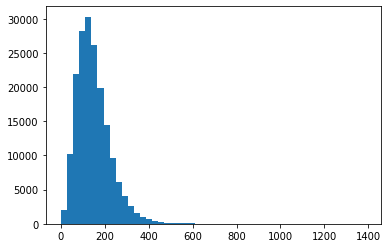

In [84]:
# Check the distribution of our sequences at character-level
import matplotlib.pyplot as plt
plt.hist(char_lens, bins=50);

Looks like most of our sequences are between 0 and 200 characters long. Let's use the numpy `percentile` function to figure out what length covers 95% of our sequences.

In [85]:
# Find what character length covers 95% of sequences
output_seq_char_len = int(np.percentile(char_lens, 95))
output_seq_char_len

290

We can use this value in our `TextVectorization` layer as the `output_sequence_length` parameter. We'll set `max_tokens` (the total number of different characters in our sequences) to number of symbols in the alphabet + space + OOV (out of vocabulary or unknown) tokens.



In [87]:
alphabet = string.ascii_lowercase + string.digits + string.punctuation
alphabet

'abcdefghijklmnopqrstuvwxyz0123456789!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~'

In [88]:
# Create char-level token vectorizer instance
NUM_CHAR_TOKENS = len(alphabet) + 2 # num characters in alphabet + space + OOV token
print(NUM_CHAR_TOKENS)
char_vectorizer = TextVectorization(max_tokens=NUM_CHAR_TOKENS,  
                                    output_sequence_length=output_seq_char_len,
                                    standardize="lower_and_strip_punctuation",
                                    name="char_vectorizer")

# Adapt character vectorizer to training characters
char_vectorizer.adapt(chars["train"])

70


Let's check out some characteristics of our vectoriser using the `get_vocabulary()` method.

In [89]:
# Check character vocabulary characteristics
char_vocab = char_vectorizer.get_vocabulary()
print(f"Number of different characters in character vocab: {len(char_vocab)}")
print(f"5 most common characters: {char_vocab[:5]}")
print(f"5 least common characters: {char_vocab[-5:]}")

Number of different characters in character vocab: 28
5 most common characters: ['', '[UNK]', 'e', 't', 'i']
5 least common characters: ['k', 'x', 'z', 'q', 'j']


We can also test it on random sequences of characters to make sure it's working.

In [90]:
# Test out character vectorizer
random_train_chars = random.choice(chars["train"])
print(f"Charified text:\n{random_train_chars}")
print(f"\nLength of chars: {len(random_train_chars.split())}")
vectorized_chars = char_vectorizer([random_train_chars])
print(f"\nVectorized chars:\n{vectorized_chars}")
print(f"\nLength of vectorized chars: {len(vectorized_chars[0])}")

Charified text:
c h i l d r e n   w i t h   b o r d e r l i n e   t o   m i l d   i n t e l l e c t u a l   d i s a b i l i t y   (   b m i d   )   h a v e   b e e n   s h o w n   t o   b e   a t   i n c r e a s e d   r i s k   f o r   p s y c h o s o c i a l   p r o b l e m s   .

Length of chars: 112

Vectorized chars:
[[11 13  4 12 10  8  2  6 20  4  3 13 22  7  8 10  2  8 12  4  6  2  3  7
  15  4 12 10  4  6  3  2 12 12  2 11  3 16  5 12 10  4  9  5 22  4 12  4
   3 19 22 15  4 10 13  5 21  2 22  2  2  6  9 13  7 20  6  3  7 22  2  5
   3  4  6 11  8  2  5  9  2 10  8  4  9 23 17  7  8 14  9 19 11 13  7  9
   7 11  4  5 12 14  8  7 22 12  2 15  9  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0 

Sequences with a length shorter than 290 (`output_seq_char_length`) get padded with zeros, to ensure all sequences passed to our model are the same length.

Due to the `standardize` parameter of `TextVectorization` being "lower_and_strip_punctuation", and the split parameter being "whitespace", by default symbols (such as @) and spaces are removed.



### Creating a character-level embedding

Just like our custom token embedding, we can create a character embedding using the `tensorflow.keras.layers.Embedding` class.

Our character-level embedding layer requires an input dimension and output dimension. The input dimension (`input_dim`) will be equal to the number of different characters in our char_vocab (`NUM_CHAR_TOKENS`). Since we're following the structure of the model in the paper (shown in its Figure 1), the output dimension of the character embedding (`output_dim`) will be 25.

In [91]:
# Create char embedding layer
char_embed = layers.Embedding(input_dim=NUM_CHAR_TOKENS, # number of different characters
                              output_dim=25, # embedding dimension of each character (same as Figure 1 in https://arxiv.org/pdf/1612.05251.pdf)
                              mask_zero=False, # don't use masks (this messes up model_5 if set to True)
                              name="char_embed")

# Test out character embedding layer
print(f"Charified text (before vectorization and embedding):\n{random_train_chars}\n")
char_embed_example = char_embed(char_vectorizer([random_train_chars]))
print(f"Embedded chars (after vectorization and embedding):\n{char_embed_example}\n")
print(f"Character embedding shape: {char_embed_example.shape}")

Charified text (before vectorization and embedding):
c h i l d r e n   w i t h   b o r d e r l i n e   t o   m i l d   i n t e l l e c t u a l   d i s a b i l i t y   (   b m i d   )   h a v e   b e e n   s h o w n   t o   b e   a t   i n c r e a s e d   r i s k   f o r   p s y c h o s o c i a l   p r o b l e m s   .

Embedded chars (after vectorization and embedding):
[[[-0.01425196 -0.00415341  0.03085691 ...  0.02075055  0.01061739
    0.03262702]
  [-0.00016413  0.00711896 -0.00371283 ... -0.03033506 -0.04704599
    0.03313652]
  [ 0.02476145 -0.044012    0.01920066 ...  0.00050933 -0.04004008
   -0.04116263]
  ...
  [-0.03460354 -0.04813455  0.04158448 ...  0.04897277  0.02856834
   -0.03005717]
  [-0.03460354 -0.04813455  0.04158448 ...  0.04897277  0.02856834
   -0.03005717]
  [-0.03460354 -0.04813455  0.04158448 ...  0.04897277  0.02856834
   -0.03005717]]]

Character embedding shape: (1, 290, 25)


As we hoped, each of the characters in our sequences get turned into a 25-dimensional embedding.

We've now got a way to turn our character-level sequences into numbers (`char_vectorizer`) as well as numerically represent them as an embedding (`char_embed`). Let's test how effective they are at encoding the information in our sequences by creating a character-level sequence model.

The model will have the same structure as our custom token embedding model (`model_1`), except it will take character-level sequences as input instead of token-level sequences.

`Input (character-level text) -> Tokenize -> Embedding -> Layers (Conv1D, GlobalMaxPool1D) -> Output (label probability)`

In [92]:
# Make Conv1D on chars only
inputs = layers.Input(shape=(1,), dtype="string")
char_vectors = char_vectorizer(inputs)
char_embeddings = char_embed(char_vectors)
x = layers.Conv1D(64, kernel_size=5, padding="same", activation="relu")(char_embeddings)
x = layers.GlobalMaxPool1D()(x)
outputs = layers.Dense(num_classes, activation="softmax")(x)
model_3 = tf.keras.Model(inputs=inputs,
                         outputs=outputs,
                         name="model_3_conv1D_char_embedding")

# Compile model
model_3.compile(loss="categorical_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

In [93]:
# Check the summary of conv1d_char_model
model_3.summary()

Model: "model_3_conv1D_char_embedding"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 1)]               0         
                                                                 
 char_vectorizer (TextVector  (None, 290)              0         
 ization)                                                        
                                                                 
 char_embed (Embedding)      (None, 290, 25)           1750      
                                                                 
 conv1d_1 (Conv1D)           (None, 290, 64)           8064      
                                                                 
 global_max_pooling1d (Globa  (None, 64)               0         
 lMaxPooling1D)                                                  
                                                                 
 dense_3 (Dense)             (None, 5

Before fitting our model on the data, we'll create char-level batched `PrefetchedDataset` objects.

In [95]:
# Create char datasets
tf_char_datasets = {}
for d in datasets:
  tf_char_datasets[d] = tf.data.Dataset.from_tensor_slices((chars[d], labels_one_hot[d])).batch(32).prefetch(tf.data.AUTOTUNE)
tf_char_datasets["train"]

<PrefetchDataset element_spec=(TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>

In [97]:
# Fit the model on chars only
model_3_history = model_3.fit(tf_char_datasets["train"],
                              steps_per_epoch=int(0.1 * len(tf_char_datasets["train"])),
                              epochs=3,
                              validation_data=tf_char_datasets["dev"],
                              validation_steps=int(0.1 * len(tf_char_datasets["dev"])))

Epoch 1/3
562/562 [==============================] - 4s 5ms/step - loss: 1.2597 - accuracy: 0.4910 - val_loss: 1.0231 - val_accuracy: 0.5974
Epoch 2/3
562/562 [==============================] - 3s 5ms/step - loss: 0.9834 - accuracy: 0.6099 - val_loss: 0.9171 - val_accuracy: 0.6393
Epoch 3/3
562/562 [==============================] - 3s 5ms/step - loss: 0.9075 - accuracy: 0.6440 - val_loss: 0.8472 - val_accuracy: 0.6722


In [99]:
# Evaluate model_3 on whole validation char dataset
model_3.evaluate(tf_char_datasets["dev"])

945/945 [==============================] - 4s 5ms/step - loss: 0.8661 - accuracy: 0.6654


[0.8660904765129089, 0.6654309630393982]

In [101]:
# Make predictions with character model only
model_3_pred_probs = model_3.predict(tf_char_datasets["dev"])
model_3_pred_probs

array([[0.10361298, 0.6164673 , 0.07266396, 0.11716439, 0.09009143],
       [0.27745306, 0.30020902, 0.01240926, 0.39276007, 0.0171687 ],
       [0.17147417, 0.10162366, 0.20157355, 0.5094807 , 0.01584787],
       ...,
       [0.00971677, 0.03082285, 0.1292677 , 0.02268505, 0.8075077 ],
       [0.0137137 , 0.07537045, 0.35940418, 0.02779947, 0.52371216],
       [0.27003768, 0.6281926 , 0.04172144, 0.0494188 , 0.01062943]],
      dtype=float32)

In [102]:
# Convert predictions to classes
model_3_preds = tf.argmax(model_3_pred_probs, axis=1)
model_3_preds

<tf.Tensor: shape=(30212,), dtype=int64, numpy=array([1, 3, 3, ..., 4, 4, 1])>

In [103]:
# Calculate Conv1D char only model results
model_3_results = calculate_results(y_true=labels_encoded["dev"],
                                        y_pred=model_3_preds)
model_3_results

{'accuracy': 66.5430954587581,
 'f1': 0.65648099292275,
 'precision': 0.6585385368100541,
 'recall': 0.6654309545875811}

## Model 4: Combining pretrained token embeddings + character embeddings (hybrid embedding)

To move closer to the model employed in the paper, we must tackle hybrid token embedding. This layer is a combination of token embeddings and character embeddings. In other words, they create a stacked embedding to represent sequences before passing them to the sequence label prediction layer.

To start replicating the model in the paper, we will:

* Create a token-level model (similar to `model_1`).
* Create a character-level model (similar to `model_3` with a slight modification to reflect the paper).
* Combine (using `layers.Concatenate`) the outputs of 1 and 2.
* Build a series of output layers on top of 3, similar to Figure 1 and section 4.2 of the paper.
* Construct a model which takes token and character-level sequences as input, and produces sequence label probabilities as output.

In [104]:
# 1. Set up token inputs/model
token_inputs = layers.Input(shape=[], dtype=tf.string, name="token_input")
token_embeddings = tf_hub_embedding_layer(token_inputs)
token_output = layers.Dense(128, activation="relu")(token_embeddings)
token_model = tf.keras.Model(inputs=token_inputs,
                             outputs=token_output)

# 2. Setup char inputs/model
char_inputs = layers.Input(shape=(1,), dtype=tf.string, name="char_input")
char_vectors = char_vectorizer(char_inputs)
char_embeddings = char_embed(char_vectors)
char_bi_lstm = layers.Bidirectional(layers.LSTM(25))(char_embeddings) # bi-LSTM shown in Figure 1 of https://arxiv.org/pdf/1612.05251.pdf
char_model = tf.keras.Model(inputs=char_inputs,
                            outputs=char_bi_lstm)

# 3. Concatenate token and char inputs (create hybrid token embedding)
token_char_concat = layers.Concatenate(name="token_char_hybrid")([token_model.output, 
                                                                  char_model.output])

# 4. Create output layers - addition of dropout discussed in 4.2 of https://arxiv.org/pdf/1612.05251.pdf
combined_dropout = layers.Dropout(0.5)(token_char_concat)
combined_dense = layers.Dense(200, activation="relu")(combined_dropout) # slightly different to Figure 1 due to different shapes of token/char embedding layers
final_dropout = layers.Dropout(0.5)(combined_dense)
output_layer = layers.Dense(num_classes, activation="softmax")(final_dropout)

# 5. Construct model with char and token inputs
model_4 = tf.keras.Model(inputs=[token_model.input, char_model.input],
                         outputs=output_layer,
                         name="model_4_token_and_char_embeddings")

In [105]:
# Get summary of token and character model
model_4.summary()

Model: "model_4_token_and_char_embeddings"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 char_input (InputLayer)        [(None, 1)]          0           []                               
                                                                                                  
 token_input (InputLayer)       [(None,)]            0           []                               
                                                                                                  
 char_vectorizer (TextVectoriza  (None, 290)         0           ['char_input[0][0]']             
 tion)                                                                                            
                                                                                                  
 universal_sentence_encoder (Ke  (None, 512)         256797824   [

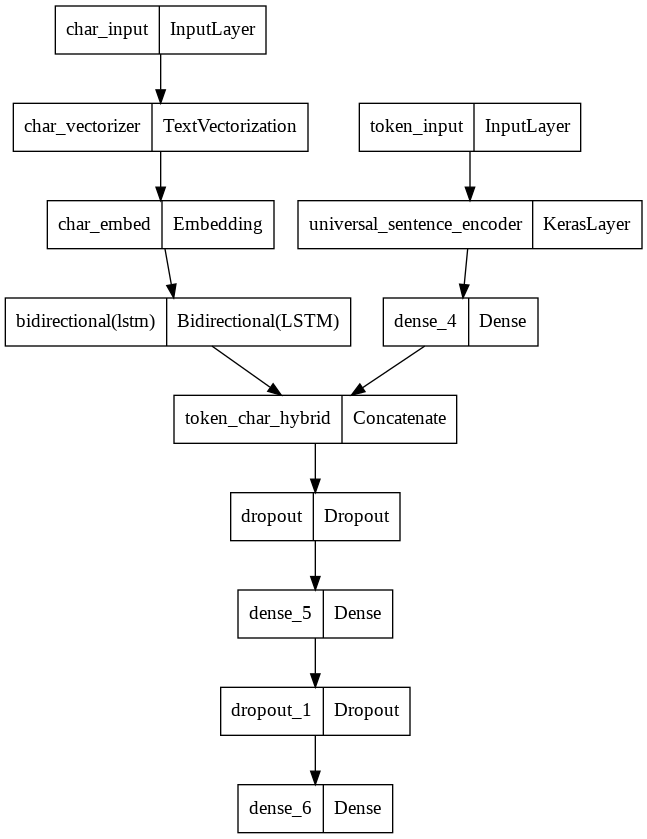

In [107]:
# Plot hybrid token and character model
plot_model(model_4)

In [108]:
# Compile token char model
model_4.compile(loss="categorical_crossentropy",
                optimizer=tf.keras.optimizers.Adam(), # section 4.2 of https://arxiv.org/pdf/1612.05251.pdf mentions using SGD, but we'll stick with Adam
                metrics=["accuracy"])

The difference with this model is that it requires two inputs, token-level sequences and character-level sequences. We can do this by creating a `tf.data.Dataset` with a tuple as its first input, for example:

`((token_data, char_data), (label))`


In [109]:
char_token_data = {}
char_token_labels = {}
char_token_dataset = {}

for d in datasets:
  char_token_data[d] = tf.data.Dataset.from_tensor_slices((sentences[d], chars[d])) # make data
  char_token_labels[d] = tf.data.Dataset.from_tensor_slices(labels_one_hot[d]) # make labels
  char_token_dataset[d] = tf.data.Dataset.zip((char_token_data[d], char_token_labels[d])) # combine data and labels
  # Prefetch and batch train data
  char_token_dataset[d] = char_token_dataset[d].batch(32).prefetch(tf.data.AUTOTUNE)

In [110]:

# Check out training char and token embedding dataset
char_token_dataset["train"], char_token_dataset["dev"]

(<PrefetchDataset element_spec=((TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None)), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>,
 <PrefetchDataset element_spec=((TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None)), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>)

In [111]:
# Fit the model on tokens and chars
model_4_history = model_4.fit(char_token_dataset["train"], # train on dataset of token and characters
                              steps_per_epoch=int(0.1 * len(char_token_dataset["train"])),
                              epochs=3,
                              validation_data=char_token_dataset["dev"],
                              validation_steps=int(0.1 * len(char_token_dataset["dev"])))

Epoch 1/3
562/562 [==============================] - 24s 34ms/step - loss: 0.9740 - accuracy: 0.6102 - val_loss: 0.7796 - val_accuracy: 0.6998
Epoch 2/3
562/562 [==============================] - 19s 33ms/step - loss: 0.7915 - accuracy: 0.6935 - val_loss: 0.7119 - val_accuracy: 0.7330
Epoch 3/3
562/562 [==============================] - 18s 32ms/step - loss: 0.7670 - accuracy: 0.7085 - val_loss: 0.6861 - val_accuracy: 0.7404


In [112]:
# Evaluate on the whole validation dataset
model_4.evaluate(char_token_dataset["dev"])

945/945 [==============================] - 20s 21ms/step - loss: 0.6892 - accuracy: 0.7372


[0.6891899108886719, 0.7371905446052551]

To make predictions with our model, since it takes multiplie inputs, we can pass the `predict()` method a tuple of token-level sequences and character-level sequences.

In [113]:
# Make predictions using the token-character model hybrid
model_4_pred_probs = model_4.predict(char_token_dataset["dev"])
model_4_pred_probs

array([[3.7432954e-01, 4.0317088e-01, 5.5697141e-03, 1.9944473e-01,
        1.7485119e-02],
       [3.6170432e-01, 4.5969731e-01, 3.6081194e-03, 1.7151099e-01,
        3.4792686e-03],
       [3.2580030e-01, 1.3548024e-01, 5.8458343e-02, 4.4187975e-01,
        3.8381308e-02],
       ...,
       [3.8409446e-04, 4.5275781e-03, 5.8982790e-02, 1.5271528e-04,
        9.3595278e-01],
       [7.5160209e-03, 5.9341460e-02, 1.8349646e-01, 2.7013919e-03,
        7.4694461e-01],
       [2.4038942e-01, 3.0798113e-01, 3.5066926e-01, 2.7621120e-02,
        7.3339120e-02]], dtype=float32)

In [114]:
# Turn prediction probabilities into prediction classes
model_4_preds = tf.argmax(model_4_pred_probs, axis=1)
model_4_preds

<tf.Tensor: shape=(30212,), dtype=int64, numpy=array([1, 1, 3, ..., 4, 4, 2])>

In [115]:
# Get results of token-char-hybrid model
model_4_results = calculate_results(y_true=labels_encoded["dev"],
                                    y_pred=model_4_preds)
model_4_results

{'accuracy': 73.71905203230504,
 'f1': 0.7340928821074343,
 'precision': 0.7364938100707697,
 'recall': 0.7371905203230504}

## Model 5: Transfer learning with pretrained token embeddings + character embeddings + positional embeddings

Abstracts are naturally ordered pieces of writing, and the position of a sentence in the abstract will likely influence what class it is most likely to fall under. For example, a sentence labelled `CONCLUSIONS` is likely to fall nearer the end of the abstract. We can leverage this information in our model, by using the position of each sentence in the abstract as an additional feature.

When we created our `preprocess_text_with_line_numbers()` function, we read in a text file of abstracts and counted the number of lines in an abstract as well as the number of each line itself. Doing this led to the `"line_number"` and `"total_lines"` columns of our DataFrames.

In [116]:
# Inspect training dataframe
df["train"].head()

,target,text,line_number,total_lines
0,OBJECTIVE,to investigate the efficacy of @ weeks of dail...,0,11
1,METHODS,a total of @ patients with primary knee oa wer...,1,11
2,METHODS,outcome measures included pain reduction and i...,2,11
3,METHODS,pain was assessed using the visual analog pain...,3,11
4,METHODS,secondary outcome measures included the wester...,4,11


These columns are features which didn't come with the training data, but can be passed to our model as a positional embedding (telling the model where the sentence appeared in the abstract). We can use these features because they will be available at test time, when predicting on new data.



### Create positional embeddings

Since our `"line_number"` and `"total_line"` columns are already numerical, we could pass them as they are to our model. But to avoid our model thinking a line with `line_number = 5` is five times greater than a line with `line_number = 1`, we'll use one-hot-encoding to encode our `line_number` and `total_lines` features. 

To do this, we can use the `tf.one_hot` utility, which returns a one-hot-encoded tensor. It accepts an array (or tensor) as input, and the depth parameter determines the dimension of the returned tensor. To figure out what we should set the depth parameter to, let's investigate the distribution of the `line_number` column.

In [118]:
# How many different line numbers are there?
df["train"]["line_number"].value_counts()

0     15000
1     15000
2     15000
3     15000
4     14992
5     14949
6     14758
7     14279
8     13346
9     11981
10    10041
11     7892
12     5853
13     4152
14     2835
15     1861
16     1188
17      751
18      462
19      286
20      162
21      101
22       66
23       33
24       22
25       14
26        7
27        4
28        3
29        1
30        1
Name: line_number, dtype: int64

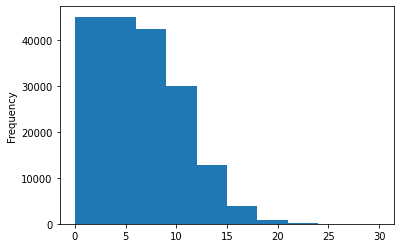

In [119]:
# Check the distribution of "line_number" column
df["train"]["line_number"].plot.hist()

Looking at the distribution of the `line_number` column, it looks like the majority of lines have a position of 15 or less. Knowing this, let's set the depth parameter of `tf.one_hot` to 15.

In [132]:
line_numbers_one_hot = {}

for d in datasets:
  line_numbers_one_hot[d] = tf.one_hot(df[d]["line_number"].to_numpy(), depth=15)

Setting the depth parameter of `tf.one_hot` to 15 means any sample with a `"line_number"` value of over 15 gets set to a tensor of all 0's, and any sample with a `"line_number"` of under 15 gets turned into a tensor of all 0's but with a 1 at the index equal to the `"line_number"` value.

In [121]:
# Check one-hot encoded "line_number" feature samples
line_numbers_one_hot["train"].shape, line_numbers_one_hot["train"][:20]

(TensorShape([180040, 15]), <tf.Tensor: shape=(20, 15), dtype=float32, numpy=
 array([[1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0.,

We can do the same for the `"total_lines"` column. First, let's find an appropriate value for the depth parameter of `tf.one_hot`.

In [123]:
# How many different numbers of lines are there?
df["train"]["total_lines"].value_counts()

11    24468
10    23639
12    22113
9     19400
13    18438
14    14610
8     12285
15    10768
7      7464
16     7429
17     5202
6      3353
18     3344
19     2480
20     1281
5      1146
21      770
22      759
23      264
4       215
24      200
25      182
26       81
28       58
3        32
30       31
27       28
Name: total_lines, dtype: int64

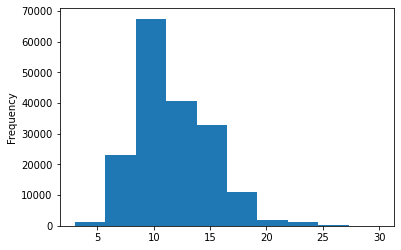

In [124]:
# Check the distribution of total lines
df["train"]["total_lines"].plot.hist();


Looking at the distribution of our `"total_lines"` column, a value of 20 looks like it covers the majority of samples.

In [125]:
total_lines_one_hot = {}

for d in datasets:
  total_lines_one_hot[d] = tf.one_hot(df[d]["total_lines"].to_numpy(), depth=20)

# Check shape and samples of total lines one-hot tensor
total_lines_one_hot["train"].shape, total_lines_one_hot["train"][:10]

(TensorShape([180040, 20]), <tf.Tensor: shape=(10, 20), dtype=float32, numpy=
 array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0.

We can now build a model that uses token embeddings, character embeddings, and our new positional embeddings. We now need to:

1. Create a token-level model (similar to `model_1`).
2. Create a character-level model (similar to `model_3` with a slight modification to reflect the paper).
3. Create a `"line_number"` model (takes in one-hot-encoded `"line_number"` tensor and passes it through a non-linear layer).
4. Create a `"total_lines"` model (takes in one-hot-encoded `"total_lines"` tensor and passes it through a non-linear layer).
5. Combine (using `layers.Concatenate`) the outputs of 1 and 2 into a token-character-hybrid embedding.
6. Combine (using `layers.Concatenate`) the outputs of 3, 4 and 5 into a token-character-positional tribrid embedding.
7. Create an output layer to accept the tribrid embedding and output predicted label probabilities.
8. Combine the inputs of 1, 2, 3, 4 and outputs of 7 into a `tf.keras.Model`.



In [126]:
# 1. Token inputs
token_inputs = layers.Input(shape=[], dtype="string", name="token_inputs")
token_embeddings = tf_hub_embedding_layer(token_inputs)
token_outputs = layers.Dense(128, activation="relu")(token_embeddings)
token_model = tf.keras.Model(inputs=token_inputs,
                             outputs=token_outputs)

# 2. Char inputs
char_inputs = layers.Input(shape=(1,), dtype="string", name="char_inputs")
char_vectors = char_vectorizer(char_inputs)
char_embeddings = char_embed(char_vectors)
char_bi_lstm = layers.Bidirectional(layers.LSTM(32))(char_embeddings)
char_model = tf.keras.Model(inputs=char_inputs,
                            outputs=char_bi_lstm)

# 3. Line numbers inputs
line_number_inputs = layers.Input(shape=(15,), dtype=tf.int32, name="line_number_input")
x = layers.Dense(32, activation="relu")(line_number_inputs)
line_number_model = tf.keras.Model(inputs=line_number_inputs,
                                   outputs=x)

# 4. Total lines inputs
total_lines_inputs = layers.Input(shape=(20,), dtype=tf.int32, name="total_lines_input")
y = layers.Dense(32, activation="relu")(total_lines_inputs)
total_line_model = tf.keras.Model(inputs=total_lines_inputs,
                                  outputs=y)

# 5. Combine token and char embeddings into a hybrid embedding
combined_embeddings = layers.Concatenate(name="token_char_hybrid_embedding")([token_model.output, 
                                                                              char_model.output])
z = layers.Dense(256, activation="relu")(combined_embeddings)
z = layers.Dropout(0.5)(z)

# 6. Combine positional embeddings with combined token and char embeddings into a tribrid embedding
z = layers.Concatenate(name="token_char_positional_embedding")([line_number_model.output,
                                                                total_line_model.output,
                                                                z])

# 7. Create output layer
output_layer = layers.Dense(5, activation="softmax", name="output_layer")(z)

# 8. Put together model
model_5 = tf.keras.Model(inputs=[line_number_model.input,
                                 total_line_model.input,
                                 token_model.input, 
                                 char_model.input],
                         outputs=output_layer)

In [127]:
# Get a summary of our token, char and positional embedding model
model_5.summary()

Model: "model_8"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 char_inputs (InputLayer)       [(None, 1)]          0           []                               
                                                                                                  
 token_inputs (InputLayer)      [(None,)]            0           []                               
                                                                                                  
 char_vectorizer (TextVectoriza  (None, 290)         0           ['char_inputs[0][0]']            
 tion)                                                                                            
                                                                                                  
 universal_sentence_encoder (Ke  (None, 512)         256797824   ['token_inputs[0][0]']     

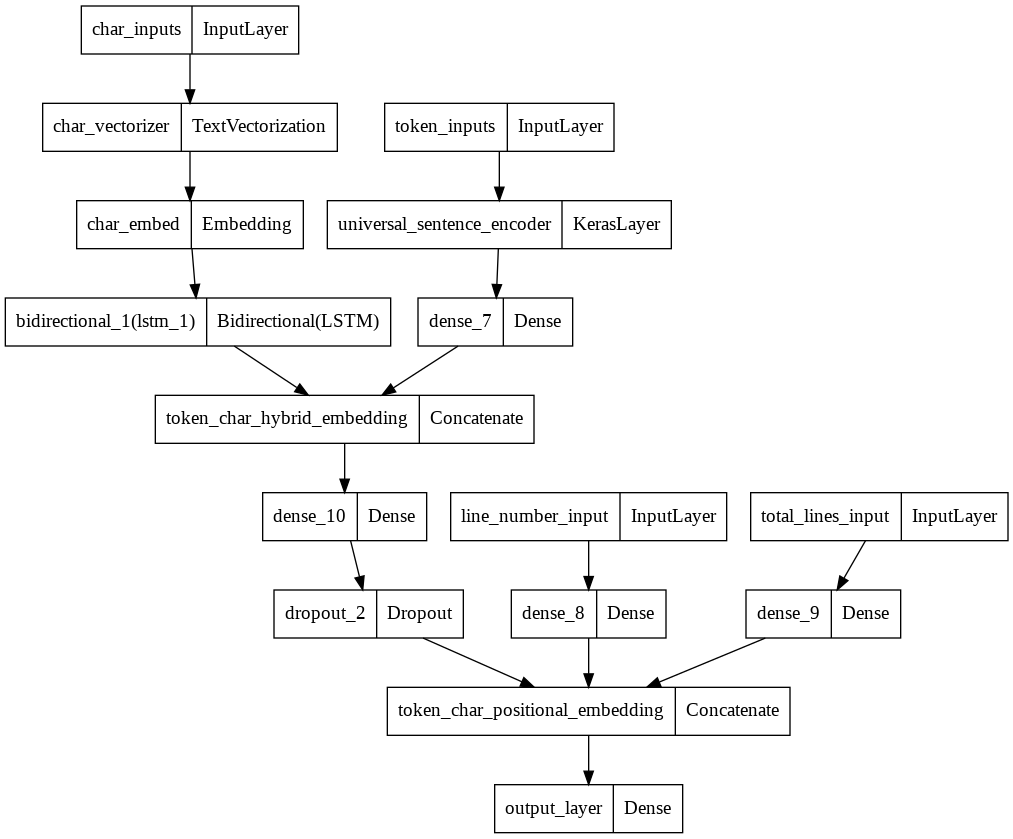

In [128]:
# Plot the token, char, positional embedding model
plot_model(model_5)

This model is now very similar to the one in the paper. A few differences remain:

* We're using pretrained TensorFlow Hub token embeddings instead of GloVe emebddings.
* We're using a Dense layer on top of our token-character hybrid embeddings instead of a bi-LSTM layer.
* Section 3.1.3 of the paper mentions a label sequence optimization layer (which helps to make sure sequence labels come out in a respectable order) but it isn't shown in Figure 1. To makeup for the lack of this layer in our model, we've created the positional embeddings layers.
* Section 4.2 of the paper mentions the token and character embeddings are updated during training, whereas our pretrained TensorFlow Hub embeddings remain frozen.
* The paper uses the SGD optimizer, we're going to stick with Adam.

In [129]:
# Check which layers of our model are trainable or not
for layer in model_5.layers:
  print(layer, layer.trainable)

<keras.engine.input_layer.InputLayer object at 0x7fa4255765d0> True
<keras.engine.input_layer.InputLayer object at 0x7fa4254e2dd0> True
<keras.layers.preprocessing.text_vectorization.TextVectorization object at 0x7fa326f8eed0> True
<tensorflow_hub.keras_layer.KerasLayer object at 0x7fa490381f10> False
<keras.layers.embeddings.Embedding object at 0x7fa326e4abd0> True
<keras.layers.core.dense.Dense object at 0x7fa4254e2ed0> True
<keras.layers.wrappers.Bidirectional object at 0x7fa42540d910> True
<keras.layers.merge.Concatenate object at 0x7fa4253780d0> True
<keras.engine.input_layer.InputLayer object at 0x7fa424df1510> True
<keras.engine.input_layer.InputLayer object at 0x7fa4255093d0> True
<keras.layers.core.dense.Dense object at 0x7fa326f14e90> True
<keras.layers.core.dense.Dense object at 0x7fa425385e50> True
<keras.layers.core.dense.Dense object at 0x7fa42541b290> True
<keras.layers.core.dropout.Dropout object at 0x7fa4252d5490> True
<keras.layers.merge.Concatenate object at 0x7fa425

We're going to introduce a new parameter to our loss function called label_smoothing. Label smoothing helps to regularize our model (prevent overfitting), by making sure it doesn't get too focused on applying one particular label to a sample.

For example, instead of having an output prediction of:

`[0.0, 0.0, 1.0, 0.0, 0.0]`

for a sample (the model is very confident the right label is index 2), its predictions will get smoothed to be something like:

`[0.01, 0.01, 0.096, 0.01, 0.01]`

giving a small activation to each of the other labels. This helps to improve generalisation.

In [130]:
# Compile token, char, positional embedding model
model_5.compile(loss=tf.keras.losses.CategoricalCrossentropy(label_smoothing=0.2), # add label smoothing (examples which are really confident get smoothed a little)
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

This time our model requires four feature inputs:

1. Train line numbers one-hot tensor (from `line_numbers_one_hot`).
2. Train total lines one-hot tensor (from `total_lines_one_hot`).
3. Token-level sequences tensor (from `sentences`).
4. Char-level sequences tensor (from `chars`).

We can pass these as tuples to our `tf.data.Dataset.from_tensor_slices()` method to create appropriately shaped and batched `PrefetchedDataset` objects.

In [133]:
pos_char_token_data = {}
pos_char_token_labels = {}
pos_char_token_dataset = {}

for d in datasets:
  pos_char_token_data[d] = tf.data.Dataset.from_tensor_slices((line_numbers_one_hot[d], # line numbers
                                                               total_lines_one_hot[d], # total lines
                                                               sentences[d], #tokens
                                                               chars[d])) #chars
  pos_char_token_labels[d] = tf.data.Dataset.from_tensor_slices(labels_one_hot[d]) # train labels
  pos_char_token_dataset[d] = tf.data.Dataset.zip((pos_char_token_data[d], pos_char_token_labels[d])) # combine data and labels
  pos_char_token_dataset[d] = pos_char_token_dataset[d].batch(32).prefetch(tf.data.AUTOTUNE) # turn into batches and prefetch appropriately

# Check input shapes
pos_char_token_dataset["train"], pos_char_token_dataset["dev"]

(<PrefetchDataset element_spec=((TensorSpec(shape=(None, 15), dtype=tf.float32, name=None), TensorSpec(shape=(None, 20), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None)), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>,
 <PrefetchDataset element_spec=((TensorSpec(shape=(None, 15), dtype=tf.float32, name=None), TensorSpec(shape=(None, 20), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None)), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>)

In [134]:
# Fit the token, char and positional embedding model
history_model_5 = model_5.fit(pos_char_token_dataset["train"],
                              steps_per_epoch=int(0.1 * len(pos_char_token_dataset["train"])),
                              epochs=3,
                              validation_data=pos_char_token_dataset["dev"],
                              validation_steps=int(0.1 * len(pos_char_token_dataset["dev"])))

Epoch 1/3
562/562 [==============================] - 25s 35ms/step - loss: 1.0991 - accuracy: 0.7220 - val_loss: 0.9816 - val_accuracy: 0.8045
Epoch 2/3
562/562 [==============================] - 18s 32ms/step - loss: 0.9660 - accuracy: 0.8177 - val_loss: 0.9482 - val_accuracy: 0.8308
Epoch 3/3
562/562 [==============================] - 20s 35ms/step - loss: 0.9491 - accuracy: 0.8268 - val_loss: 0.9365 - val_accuracy: 0.8351


In [135]:
# Make predictions with token-char-positional hybrid model
model_5_pred_probs = model_5.predict(pos_char_token_dataset["dev"], verbose=1)
model_5_pred_probs

945/945 [==============================] - 24s 23ms/step


array([[0.49820745, 0.11111819, 0.00969543, 0.36156684, 0.01941213],
       [0.57477   , 0.07918168, 0.03962973, 0.29825395, 0.0081646 ],
       [0.26630282, 0.10709   , 0.12236045, 0.42965785, 0.07458889],
       ...,
       [0.03982737, 0.10815955, 0.04778596, 0.03299393, 0.7712332 ],
       [0.02993314, 0.32051298, 0.07703167, 0.02501886, 0.5475033 ],
       [0.22842224, 0.5818366 , 0.11113821, 0.03602669, 0.04257623]],
      dtype=float32)

In [136]:
# Turn prediction probabilities into prediction classes
model_5_preds = tf.argmax(model_5_pred_probs, axis=1)
model_5_preds

<tf.Tensor: shape=(30212,), dtype=int64, numpy=array([0, 0, 3, ..., 4, 4, 1])>

In [137]:
# Calculate results of token-char-positional hybrid model
model_5_results = calculate_results(y_true=labels_encoded["dev"],
                                    y_pred=model_5_preds)
model_5_results

{'accuracy': 83.49662385806964,
 'f1': 0.8341093535696383,
 'precision': 0.8338670951504454,
 'recall': 0.8349662385806964}

## Compare model results

Since all of our model results are in dictionaries, let's combine them into a `pandas` DataFrame to visualize them.

In [138]:
# Combine model results into a DataFrame
all_model_results = pd.DataFrame({"baseline": baseline_results,
                                  "custom_token_embed_conv1d": model_1_results,
                                  "pretrained_token_embed": model_2_results,
                                  "custom_char_embed_conv1d": model_3_results,
                                  "hybrid_char_token_embed": model_4_results,
                                  "tribrid_pos_char_token_embed": model_5_results})
all_model_results = all_model_results.transpose()
all_model_results

,accuracy,precision,recall,f1
baseline,72.183238,0.718647,0.721832,0.698925
custom_token_embed_conv1d,78.578048,0.782434,0.785780,0.783129
pretrained_token_embed,71.349133,0.713535,0.713491,0.710459
custom_char_embed_conv1d,66.543095,0.658539,0.665431,0.656481
hybrid_char_token_embed,73.719052,0.736494,0.737191,0.734093
tribrid_pos_char_token_embed,83.496624,0.833867,0.834966,0.834109


In [139]:
# Reduce the accuracy to same scale as other metrics
all_model_results["accuracy"] = all_model_results["accuracy"]/100.

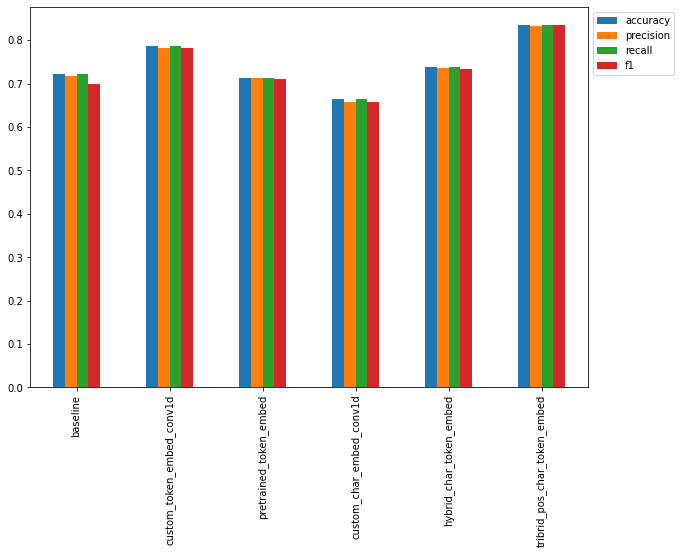

In [140]:
# Plot and compare all of the model results
all_model_results.plot(kind="bar", figsize=(10, 7)).legend(bbox_to_anchor=(1.0, 1.0));

Since the paper compares their tested models F1-scores on the test dataset, let's take a look at our model's F1-scores.

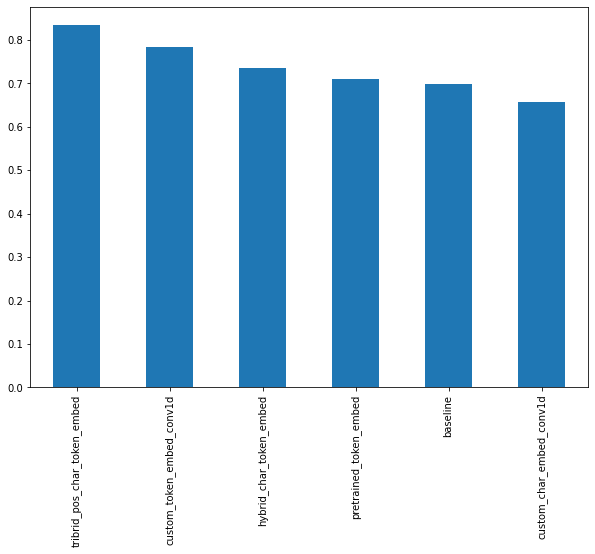

In [141]:
# Sort model results by f1-score
all_model_results.sort_values("f1", ascending=False)["f1"].plot(kind="bar", figsize=(10, 7));

Based on F1-scores, it looks like our tribrid embedding model performs the best. In comparison to the results reported in Table 3 of the paper, our models F1-score is still underperforming (the model in the paper achieves an F1-score of 90.0 on the 20k RCT dataset).


## Evaluate best model on test dataset

To make our models performance evaluation more comparable with the results reported in the paper, let's make predictions on the test dataset and evaluate them.

In [143]:
# Make predictions on the test dataset
test_pred_probs = model_5.predict(pos_char_token_dataset["test"],
                                       verbose=1)
test_preds = tf.argmax(test_pred_probs, axis=1)
test_preds[:10]

942/942 [==============================] - 19s 20ms/step


<tf.Tensor: shape=(10,), dtype=int64, numpy=array([3, 0, 2, 2, 4, 4, 4, 1, 4, 0])>

In [144]:
# Evaluate loaded model test predictions
loaded_model_test_results = calculate_results(y_true=labels_encoded["test"],
                                              y_pred=test_preds)
loaded_model_test_results

{'accuracy': 82.96665007466402,
 'f1': 0.8286786137577984,
 'precision': 0.8282124567075865,
 'recall': 0.8296665007466402}

It seems our best model still has some way to go to match the performance of the results in the paper. However, our model has only been trained on 20,000 out of the total ~180,000 sequences in the RCT 20k dataset. We also haven't fine-tuned our pretrained embeddings (the paper fine-tunes GloVe embeddings). There are thus a few extensions which could improve model performance further.

## Find the most wrong predictions

The most wrong predictions are samples where the model has made a prediction with a high probability but has gotten it wrong (the models prediction disagreess with the ground truth label). Looking at the most wrong predictions can give us valuable information on how to improve further models, or fix the labels in our data.

Let's visualize the most wrong predictions from the test dataset. First we'll convert all of our integer-based test predictions into their string-based class names.

In [146]:
# Get list of class names of test predictions
test_pred_classes = [label_encoder.classes_[pred] for pred in test_preds]

Now we'll extend our test DataFame with a few values:

* A `"prediction"` (string) column containing our models prediction for a given sample.
* A `"pred_prob"` (float) column containing the model's maximum prediction probabiliy for a given sample.
* A `"correct"` (bool) column to indicate whether or not the model's prediction matches the samples target label.

In [148]:
df["test"]["prediction"] = test_pred_classes # create column with test prediction class names
df["test"]["pred_prob"] = tf.reduce_max(test_pred_probs, axis=1).numpy() # get the maximum prediction probability
df["test"]["correct"] = df["test"]["prediction"] == df["test"]["target"] # create binary column for whether the prediction is right or not
df["test"].head(20)

,target,text,line_number,total_lines,prediction,pred_prob,correct
0,BACKGROUND,this study analyzed liver function abnormaliti...,0,8,OBJECTIVE,0.495064,False
1,RESULTS,a post hoc analysis was conducted with the use...,1,8,BACKGROUND,0.331537,False
2,RESULTS,liver function tests ( lfts ) were measured at...,2,8,METHODS,0.784885,False
3,RESULTS,survival analyses were used to assess the asso...,3,8,METHODS,0.641647,False
4,RESULTS,the percentage of patients with abnormal lfts ...,4,8,RESULTS,0.695466,True
5,RESULTS,when mean hemodynamic profiles were compared i...,5,8,RESULTS,0.865933,True
6,RESULTS,multivariable analyses revealed that patients ...,6,8,RESULTS,0.522776,True
7,CONCLUSIONS,abnormal lfts are common in the adhf populatio...,7,8,CONCLUSIONS,0.476605,True
8,CONCLUSIONS,elevated meld-xi scores are associated with po...,8,8,RESULTS,0.451310,False
9,BACKGROUND,minimally invasive endovascular aneurysm repai...,0,12,BACKGROUND,0.589653,True


We can sort our DataFrame to find the samples with the highest `"pred_prob"` where the prediction was wrong (`"correct" == False`):

In [149]:
# Find top 100 most wrong samples (note: 100 is an abitrary number, you could go through all of them if you wanted)
top_100_wrong = df["test"][df["test"]["correct"] == False].sort_values("pred_prob", ascending=False)[:100]
top_100_wrong

,target,text,line_number,total_lines,prediction,pred_prob,correct
1827,CONCLUSIONS,nct@ ( clinicaltrials.gov ) .,18,18,BACKGROUND,0.949125,False
8545,METHODS,pretest-posttest .,1,11,BACKGROUND,0.941503,False
2388,RESULTS,the primary endpoint is the cumulative three-y...,4,13,METHODS,0.939608,False
16347,BACKGROUND,to evaluate the effects of the lactic acid bac...,0,12,OBJECTIVE,0.938746,False
18720,RESULTS,non-diffuse-trickling '' ) .,8,15,BACKGROUND,0.934492,False
...,...,...,...,...,...,...,...
18789,BACKGROUND,these programs were evaluated in a head-to-hea...,3,12,METHODS,0.841655,False
13491,RESULTS,we used multivariable-adjusted cox regression ...,5,14,METHODS,0.839732,False
9993,METHODS,this study provides class i evidence that in p...,11,11,CONCLUSIONS,0.839677,False
12456,RESULTS,icd patients were randomized @:@ to automatic ...,1,13,METHODS,0.839085,False


Let's write some code to visualize the most wrong predictions.

In [150]:
# Investigate top wrong preds
for row in top_100_wrong[0:10].itertuples(): # adjust indexes to view different samples
  _, target, text, line_number, total_lines, prediction, pred_prob, _ = row
  print(f"Target: {target}, Pred: {prediction}, Prob: {pred_prob}, Line number: {line_number}, Total lines: {total_lines}\n")
  print(f"Text:\n{text}\n")
  print("-----\n")

Target: CONCLUSIONS, Pred: BACKGROUND, Prob: 0.9491254687309265, Line number: 18, Total lines: 18

Text:
nct@ ( clinicaltrials.gov ) .

-----

Target: METHODS, Pred: BACKGROUND, Prob: 0.9415032863616943, Line number: 1, Total lines: 11

Text:
pretest-posttest .

-----

Target: RESULTS, Pred: METHODS, Prob: 0.9396077990531921, Line number: 4, Total lines: 13

Text:
the primary endpoint is the cumulative three-year hiv incidence .

-----

Target: BACKGROUND, Pred: OBJECTIVE, Prob: 0.9387462139129639, Line number: 0, Total lines: 12

Text:
to evaluate the effects of the lactic acid bacterium lactobacillus salivarius on caries risk factors .

-----

Target: RESULTS, Pred: BACKGROUND, Prob: 0.9344920516014099, Line number: 8, Total lines: 15

Text:
non-diffuse-trickling '' ) .

-----

Target: CONCLUSIONS, Pred: METHODS, Prob: 0.9344913959503174, Line number: 4, Total lines: 6

Text:
symptom outcomes will be assessed and estimates of cost-effectiveness made .

-----

Target: CONCLUSIONS, Pre

Inspecting the above examples, there are clear cases of mis-labelling where the grouth truth labels are incorrect. In such cases, it may make sense to update the training samples to correct instances of incorrect labelling. 

There are also instances where sentences could have legitimately been labelled under one of several classes, for example either as `OBJECTIVE` or `BACKGROUND`. As such, the model predicting another class than the label provided is understandable.